# Stock Prices Prediction Using LSTM

In [1]:
# Import all the libraries required
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Accquiring stock data starting from 30 July 2020 to 27 August 2022 and preview the data
stock_data = yf.download('BYDDY', start='2020-07-31', end='2022-08-27')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-30,18.709999,18.969999,18.580000,18.730000,18.705582,88600
2020-07-31,19.020000,19.100000,18.799999,18.889999,18.865374,48400
2020-08-03,19.330000,19.410000,19.209999,19.299999,19.274839,124000
2020-08-04,19.850000,20.139999,19.820000,20.080000,20.053823,57500
2020-08-05,20.180000,20.290001,20.090000,20.160000,20.133717,60200
...,...,...,...,...,...,...
2022-08-22,69.800003,70.519997,69.800003,70.199997,70.199997,77400
2022-08-23,69.000000,69.809998,67.889999,69.019997,69.019997,158700
2022-08-24,66.690002,67.550003,66.000000,67.070000,67.070000,138700


Text(0, 0.5, 'Prices ($)')

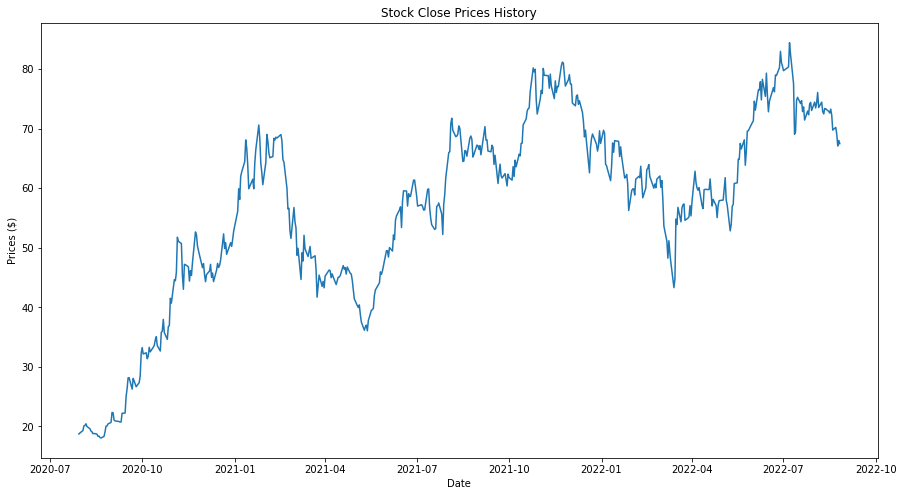

In [3]:
# Visualizing Sotkc Prices History

plt.figure(figsize=(15, 8))        # Setting up the plot figure size
plt.title('Stock Close Prices History')  # Setting up the plot figure title
plt.plot(stock_data['Close'])      # Create a line chart for historical close prices of LI Auto
plt.xlabel('Date')                 # Set the x-axis and y-axis labels
plt.ylabel('Prices ($)')

In [4]:
# Preparation of training set

close_prices = stock_data['Close']                        # Extract the closing prices from the acquired stock data and convert it to a number series
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)           # Calculate the data size for 80% of the dataset. The math.ceil method is to ensure the data size is rounded up to an integer

scaler = MinMaxScaler(feature_range=(0,1))                # Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. We also reshape our normalized data into a two-dimensional array
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]         # Set apart the first 80% of the stock data as the training set

x_train = []                                              # Create an empty list for a sequence of feature data (x_train) and a sequence of label data (y_train)
y_train = []

for i in range(60, len(train_data)):                     # Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label data (y_train)
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)  #Convert the feature data (x_train) and label data (y_train) into Numpy array as it is the data format accepted by the Tensorflow when training a neural network model. Reshape again the x_train and y_train into a three-dimensional array as part of the requirement to train a LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
y_train

array([0.26683742, 0.24966099, 0.28175382, 0.28431519, 0.3533223 ,
       0.34111797, 0.40063282, 0.39792075, 0.41901464, 0.50791019,
       0.49751395, 0.49193916, 0.41193311, 0.37622422, 0.43935514,
       0.43845115, 0.433027  , 0.39686606, 0.4233841 , 0.41117977,
       0.44297125, 0.52131992, 0.51393704, 0.48530962, 0.46285975,
       0.43091762, 0.44131387, 0.41389184, 0.39535938, 0.41343985,
       0.4226307 , 0.43935514, 0.40665967, 0.41735726, 0.39566073,
       0.42489078, 0.44176586, 0.43136962, 0.43664306, 0.44975144,
       0.51634776, 0.47943348, 0.49434989, 0.46481848, 0.49419918,
       0.48455628, 0.50248611, 0.52312795, 0.57330119, 0.63025467,
       0.60343529, 0.66189545, 0.67289439, 0.69911102, 0.75410577,
       0.73301188, 0.69067351, 0.63055602, 0.65466327, 0.63055602,
       0.69489227, 0.72879313, 0.79177339, 0.75757124, 0.69534426,
       0.671237  , 0.64080162, 0.69685106, 0.76796743, 0.75184569,
       0.722013  , 0.70890463, 0.71206869, 0.75817394, 0.75410

In [6]:
# Preparation of test set

test_data = scaled_data[training_data_len-60: , : ]    # Extract the closing prices from our normalized dataset (the last 20% of the dataset)
x_test = []                                            # Similar to the training set, we will have to create feature data (x_test) and label data (y_test)from our test set
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)                             #Convert the feature data (x_test) and label data (y_test) into Numpy array. Reshape again the x_test and y_test into a three-dimensional array
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
# Setting Up LSTM Network Architecture

# Define a Sequential model which consists of a linear stack of layers
model = keras.Sequential()

# Add a LSTM layer by giving it 100 network units. Set the return_sequence to true so that the output of the layer will be another sequence of the same length
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another LSTM layer with also 50 network units. But we set the return_sequence to false for this time to only return the last output in the output sequence
model.add(layers.LSTM(50, return_sequences=False))

# Add a densely connected neural network layer with 25 network units
model.add(layers.Dense(25))

# At last, add a densely connected layer that specifies the output of 1 network unit
model.add(layers.Dense(1))

# Show the summary of our LSTM network architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 72,301
Trainable params: 72,301
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Training LSTM Model

# Adopt “adam” optimizer and set the mean square error as loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model by fitting it with the training set. We can try with batch_size of 3 and run the training for 50 epochs
model.fit(x_train, y_train, batch_size=3, epochs=20)

Epoch 1/20
120/120 [==============================] - 6s 23ms/step - loss: 0.0179
Epoch 2/20
120/120 [==============================] - 3s 27ms/step - loss: 0.0045
Epoch 3/20
120/120 [==============================] - 3s 27ms/step - loss: 0.0044
Epoch 4/20
120/120 [==============================] - 3s 24ms/step - loss: 0.0038
Epoch 5/20
120/120 [==============================] - 3s 23ms/step - loss: 0.0028
Epoch 6/20
120/120 [==============================] - 3s 23ms/step - loss: 0.0027
Epoch 7/20
120/120 [==============================] - 3s 27ms/step - loss: 0.0028
Epoch 8/20
120/120 [==============================] - 4s 30ms/step - loss: 0.0024
Epoch 9/20
120/120 [==============================] - 3s 25ms/step - loss: 0.0026
Epoch 10/20
120/120 [==============================] - 3s 25ms/step - loss: 0.0026
Epoch 11/20
120/120 [==============================] - 3s 23ms/step - loss: 0.0023
Epoch 12/20
120/120 [==============================] - 3s 23ms/step - loss: 0.0025
Epoch 13/20
1

In [9]:
# Model Evaluation

# Apply the model to predict the stock prices based on the test set
predictions = model.predict(x_test)

# Use the inverse_transform method to denormalize the predicted stock prices
predictions = scaler.inverse_transform(predictions)

# Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result
rmse = np.sqrt(pow(np.mean(predictions - y_test),2))

# Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Calculate RMSE Root Mean Square Error
print("RMSE on train set = %0.4f" % rmse)

# Calculate MAPE Mean Absolute Percentage Error
print("MAPE on train set = %0.4f%%" % mape)

4/4 [==============================] - 1s 17ms/step
RMSE on train set = 0.5988
MAPE on train set = 14.0795%


In [10]:
predictions

array([[55.81395 ],
       [57.46365 ],
       [56.488907],
       [58.146553],
       [62.828205],
       [62.121254],
       [60.921143],
       [60.331474],
       [60.647793],
       [58.234985],
       [57.324665],
       [59.875885],
       [60.61903 ],
       [60.605873],
       [62.050827],
       [60.413002],
       [58.049046],
       [58.51265 ],
       [57.893345],
       [56.12439 ],
       [57.44607 ],
       [58.496975],
       [58.714863],
       [58.73664 ],
       [60.327866],
       [62.216045],
       [59.318333],
       [57.905197],
       [54.204567],
       [54.289146],
       [56.988926],
       [58.03727 ],
       [61.061977],
       [61.747692],
       [65.09387 ],
       [65.63293 ],
       [67.932076],
       [67.388885],
       [68.626   ],
       [64.92848 ],
       [66.46522 ],
       [70.07135 ],
       [70.622   ],
       [71.81074 ],
       [72.11867 ],
       [75.28036 ],
       [74.04143 ],
       [77.14831 ],
       [77.36899 ],
       [78.68326 ],


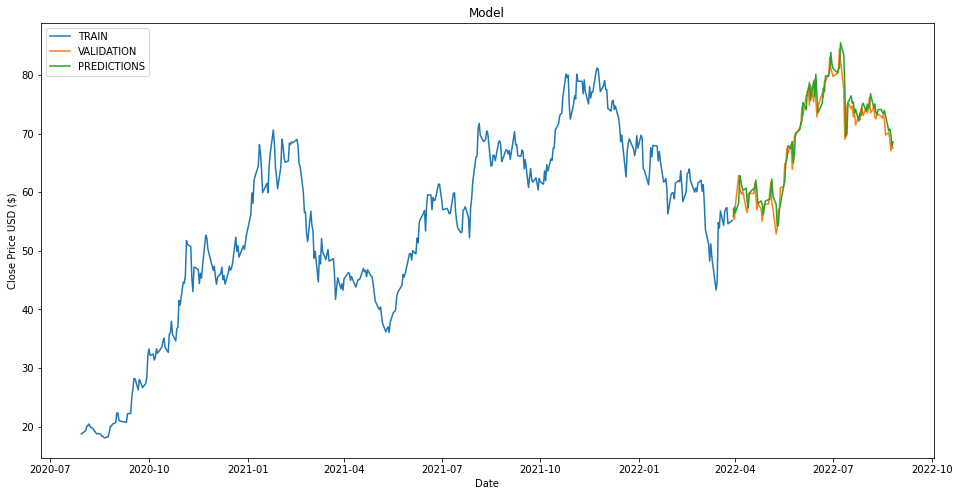

In [11]:
# Visualizing the Predicted Prices

# Use the filter method to only retain the closing price column in the dataframe
data = stock_data.filter(['Close'])

# Split our stock data into three plotting regions: training, validation and prediction
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions

# Configure the chart figure size, title, x-axis & y-axis label and legends
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['TRAIN', 'VALIDATION', 'PREDICTIONS'], loc='upper left')
plt.show()

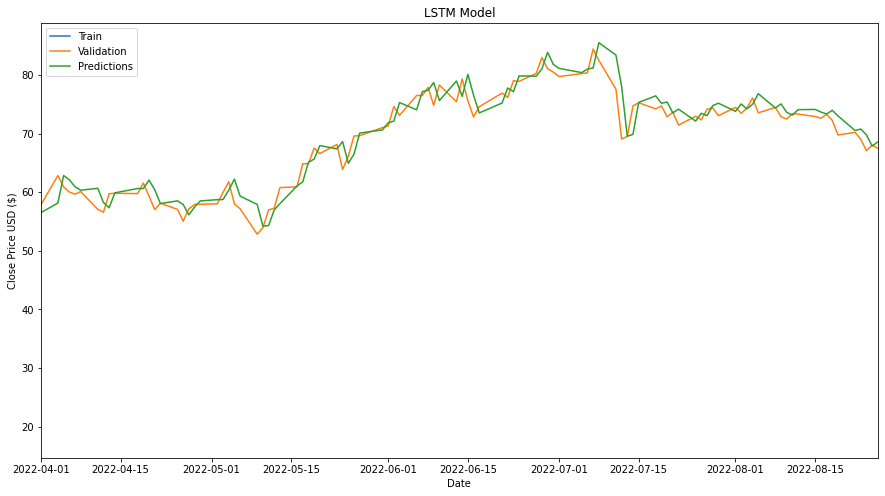

In [12]:
import time
from datetime import date
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(15,8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='upper left')
plt.xlim([date(2022, 4, 1), date(2022, 8, 26)])
plt.show()

In [13]:
stock_data1 = pd.read_csv("BYDDY_stocks.csv")
stock_data1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-30,18.709999,18.969999,18.580000,18.730000,18.705582,88600
1,2020-07-31,19.020000,19.100000,18.799999,18.889999,18.865374,48400
2,2020-08-03,19.330000,19.410000,19.209999,19.299999,19.274839,124000
3,2020-08-04,19.850000,20.139999,19.820000,20.080000,20.053823,57500
4,2020-08-05,20.180000,20.290001,20.090000,20.160000,20.133717,60200
...,...,...,...,...,...,...,...
519,2022-08-22,69.800003,70.519997,69.800003,70.199997,70.199997,77400
520,2022-08-23,69.000000,69.809998,67.889999,69.019997,69.019997,158700
521,2022-08-24,66.690002,67.550003,66.000000,67.070000,67.070000,138700
522,2022-08-25,67.150002,68.010002,66.220001,68.010002,68.010002,274600


In [14]:
stock_data1.iloc[-1]

Date         2022-08-26
Open          68.620003
High          69.239998
Low           67.360001
Close         67.470001
Adj Close     67.470001
Volume           227100
Name: 523, dtype: object

In [15]:
X_input = stock_data.iloc[-60:].Close.values               # getting last 60 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,60,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 60, 1)


array([[[0.43458222],
        [0.34755039],
        [0.54236337],
        [0.54178688],
        [0.62247862],
        [0.44610943],
        [0.64610951],
        [0.48069191],
        [0.70547544],
        [0.49164262],
        [0.33141213],
        [0.43285319],
        [0.56599427],
        [0.52449564],
        [0.68760815],
        [0.68184455],
        [0.75907777],
        [0.91585019],
        [0.80576395],
        [0.77291094],
        [0.72910678],
        [0.75792523],
        [0.76484137],
        [1.        ],
        [0.88876078],
        [0.60576387],
        [0.11412124],
        [0.14005767],
        [0.44034582],
        [0.4714698 ],
        [0.41095089],
        [0.43976933],
        [0.33314117],
        [0.37867437],
        [0.25129689],
        [0.33832872],
        [0.30259369],
        [0.40634027],
        [0.42247853],
        [0.34409232],
        [0.42536011],
        [0.36829971],
        [0.41786747],
        [0.51815554],
        [0.37233427],
        [0

In [16]:
LSTM_prediction = scaler.inverse_transform(model.predict(X_input))
print("LSTM prediction, Close price prediction for 8/29/2022 :", LSTM_prediction[0,0])

1/1 [==============================] - 0s 27ms/step
LSTM prediction, Close price prediction for 8/29/2022 : 68.0427


In [17]:
# Accquiring stock data starting from 29 August 2022 to 30 August 2022 and preview the data
stock_data2 = yf.download('BYDDY', start='2022-08-29', end='2022-08-30')
stock_data2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-29,68.279999,69.849998,68.059998,69.68,69.68,171800
